In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

c:\Users\Admin\anaconda3\envs\quant\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed


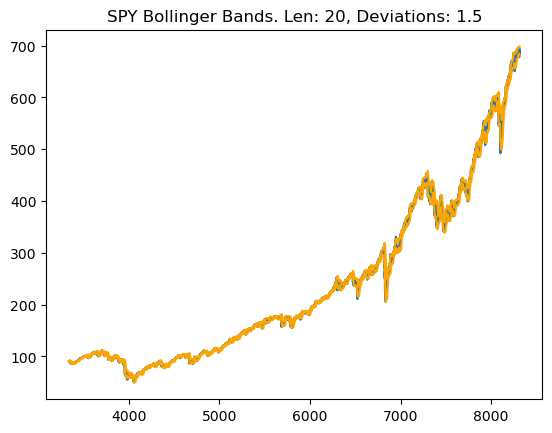

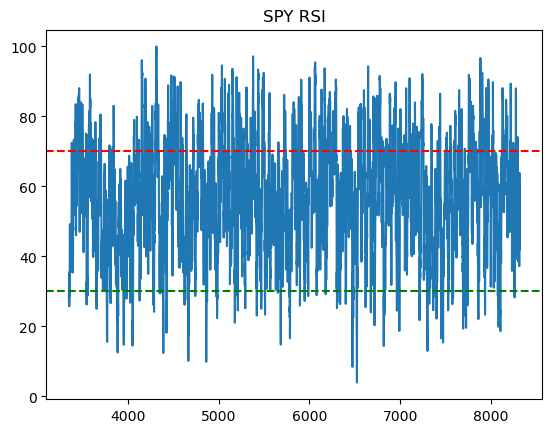

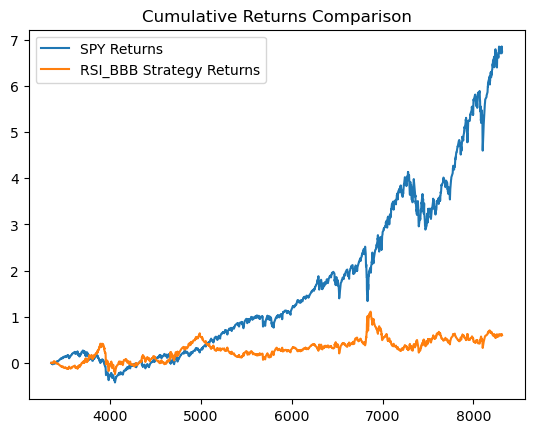

Price,Date,Close,High,Low,Open,Volume,BB_SMA,STD,Upper_Band,Lower_Band,BB_strategy,signal,RSI,RSI_strategy,RSI_signal,full_strategy,strategy,Asset_returns,strategy_returns
3350,2006-05-17,87.915054,89.474452,87.859608,89.176429,144789500,90.666152,0.949163,92.089896,89.242408,-1.0,NaN,28.768297,NaN,1.0,NaN,NaN,NaN,NaN
3351,2006-05-18,87.471481,88.538799,87.402176,88.261573,87906300,90.495657,1.185338,92.273664,88.717649,-1.0,NaN,27.169984,1.0,1.0,0.0,0.0,-0.005045,0.000000
3352,2006-05-19,88.088295,88.358589,87.187316,87.928893,124309400,90.355311,1.296500,92.300061,88.410562,-1.0,NaN,35.449490,1.0,NaN,0.0,0.0,0.001971,0.000000
3353,2006-05-22,87.416039,88.136825,86.979411,87.519999,110852800,90.189668,1.448926,92.363057,88.016280,-1.0,NaN,26.830825,1.0,1.0,0.0,0.0,-0.005676,0.000000
3354,2006-05-23,86.750702,88.455636,86.750702,88.143760,92006500,90.009472,1.638969,92.467926,87.551018,-1.0,NaN,25.762150,1.0,1.0,0.0,0.0,-0.013244,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8301,2026-01-22,688.979980,691.130005,686.919983,689.849976,77112200,688.821997,4.309109,695.285660,682.358334,-1.0,NaN,56.979055,1.0,NaN,0.0,1.0,6.836883,0.618264
8309,2026-02-03,689.530029,696.960022,684.030029,696.210022,107904600,691.196994,4.193050,697.486569,684.907419,0.0,1.0,45.818546,1.0,NaN,1.0,1.0,6.843139,0.619556
8311,2026-02-05,677.619995,683.690002,675.789978,680.940002,113610800,690.317993,5.256641,698.202955,682.433031,0.0,1.0,37.247027,1.0,NaN,1.0,1.0,6.707667,0.591582
8312,2026-02-06,690.619995,692.309998,680.849976,681.460022,89127600,690.373492,5.253520,698.253773,682.493212,-1.0,NaN,49.254388,1.0,NaN,0.0,1.0,6.855537,0.622116


In [5]:
ticker = "SPY"
interval = '1d'

#set period based on interval
if interval == '1h':
    period = "max"
else:
    period = "max"

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

LOOKBACK = -5000

BB_LENGTH = 20 
devs= 1.5

def get_data(ticker, lookback=LOOKBACK, interval=interval, period=period):
    df = yf.download(ticker, period = period, auto_adjust=True, interval=interval)
    #reset index to get datetime as a column
    df = df.reset_index()

    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    #only return data after lookback
    return df.iloc[lookback:,:]

def add_bollinger_bands(df, BB_LENGTH, devs): 
    df['BB_SMA'] = df['Close'].rolling(window=BB_LENGTH).mean() 
    df['STD'] = df['Close'].rolling(window=BB_LENGTH).std()
    df['Upper_Band'] = df['BB_SMA'] + (df['STD'] * devs)
    df['Lower_Band'] = df['BB_SMA'] - (df['STD'] * devs)

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'])
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{ticker} Bollinger Bands. Len: {BB_LENGTH}, Deviations: {devs}')

    return df

def BB_strategy(df):
    df['BB_strategy'] = 0

    conditions = [
        (df['Close'] > df["Upper_Band"]), # Condition 1: Short
        (df['Close'] < df["Lower_Band"]),
        (df['Close'] > df['BB_SMA']) & (df['Close'].shift(1) < df['BB_SMA']), 
        ((df['Close'] < df['BB_SMA']) & (df['Close'].shift(1) > df['BB_SMA']))   
    ]
    choices = [1, -1, 0, 0]
    df['signal'] = np.select(conditions, choices, default=np.nan)

    df['BB_strategy'] = df['signal'].ffill()
    df['BB_strategy'] = df['BB_strategy'].fillna(0)

    df['BB_strategy'] = df['BB_strategy'].shift(1)
    return df

def add_RSI(df, RSI_LENGTH):

    delta = df['Close'].diff()

    #separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    #calculate average gain and loss
    avg_gain = gain.rolling(window=RSI_LENGTH).mean()
    avg_loss = loss.rolling(window=RSI_LENGTH).mean()

    #calculate RSI
    rs = avg_gain / avg_loss 
    df['RSI'] = 100 - (100 / (1 + rs))

    #plot RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} RSI')

    return df.dropna()

def RSI_strategy(df, OVERBOUGHT, OVERSOLD):
    df['RSI_strategy'] = 0

    conditions = [
        (df['RSI'] > OVERBOUGHT), 
        (df['RSI'] < OVERSOLD)   ]
    choices = [-1, 1]
    
    df['RSI_signal'] = np.select(conditions, choices, default=np.nan)

    df['RSI_strategy'] = df['RSI_signal'].ffill()
    df['RSI_strategy'] = df['RSI_strategy'].fillna(0)
    df['RSI_strategy'] = df['RSI_strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['full_strategy'] = df['RSI_strategy'] + df['BB_strategy']

    conditions = [
        (df['full_strategy'] >0), 
        (df['full_strategy'] <0)   ]
    choices = [1, -1]
    
    df['signal'] = np.select(conditions, choices, default=np.nan)

    df['strategy'] = df['signal'].ffill()
    df['strategy'] = df['strategy'].fillna(0)
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='RSI_BBB Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data(ticker, LOOKBACK, interval, period)
    df = add_bollinger_bands(df, BB_LENGTH, devs)
    df = BB_strategy(df)
    df = add_RSI(df, RSI_LENGTH)
    df = RSI_strategy(df, OVERBOUGHT, OVERSOLD)
    df = add_full_strategy(df)
    df = test_strategy(df)
    plt.show()
    return df

df = main()
df